In [399]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

## Import the data

In [400]:
X_train_scaled = pd.read_pickle('data/X_train_scaled.pkl')
X_test_scaled = pd.read_pickle('data/X_test_scaled.pkl')

# X_test_scaled = pd.read_pickle('data/X_test_final.pkl')
# X_train_scaled = pd.read_pickle('data/X_train_final.pkl')

y_train_motor = pd.read_pickle('data/y_train_motor.pkl')
y_test_motor = pd.read_pickle('data/y_test_motor.pkl')
y_train_total = pd.read_pickle('data/y_train_total.pkl')
y_test_total = pd.read_pickle('data/y_test_total.pkl')

In [401]:
X_train_scaled.describe()

,sex,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,RPDE,DFA,PPE,age,test_time,Shimmer(dB),HNR
count,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000
mean,0.321139,0.005252,0.000039,0.002511,0.002715,0.007533,0.030499,0.015398,0.017834,0.024884,0.046192,0.023636,0.533722,0.649956,0.207460,0.543022,0.431632,0.130319,0.514967
std,0.466968,0.002611,0.000025,0.001433,0.001428,0.004298,0.019493,0.010414,0.012049,0.015873,0.031242,0.028830,0.101901,0.067662,0.080160,0.275003,0.247484,0.090825,0.118556
min,0.000000,0.000830,0.000002,0.000330,0.000430,0.000980,0.003060,0.001610,0.001940,0.002490,0.004840,0.000286,0.239450,0.514040,0.021983,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.003400,0.000021,0.001490,0.001720,0.004460,0.017970,0.008615,0.010110,0.014675,0.025840,0.009909,0.458145,0.593795,0.149275,0.310345,0.222369,0.071502,0.436510
50%,0.000000,0.004640,0.000032,0.002120,0.002370,0.006350,0.025900,0.012700,0.014930,0.021560,0.038110,0.017005,0.536480,0.645750,0.197740,0.551724,0.422372,0.109053,0.513246
75%,1.000000,0.006440,0.000050,0.003130,0.003330,0.009380,0.037040,0.019035,0.021865,0.030710,0.057115,0.028546,0.612245,0.707145,0.254890,0.793103,0.641707,0.161523,0.596449
max,1.000000,0.017780,0.000167,0.008300,0.012570,0.024910,0.239150,0.162670,0.162460,0.205850,0.488020,0.445940,0.831480,0.836270,0.558270,1.000000,1.000000,1.000000,1.000000


In [402]:
mean_values = X_train_scaled.mean()

threshold = 1e-2  

small_columns = mean_values[abs(mean_values) < threshold].index

X_train_scaled = X_train_scaled.drop(columns=small_columns)
X_test_scaled = X_test_scaled.drop(columns=small_columns)

print("Remaining columns after dropping small-value columns:", X_train_scaled.columns)
print("Number of remaining columns:", len(X_train_scaled.columns))

Remaining columns after dropping small-value columns: Index(['sex', 'Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11',
       'Shimmer:DDA', 'NHR', 'RPDE', 'DFA', 'PPE', 'age', 'test_time',
       'Shimmer(dB)', 'HNR'],
      dtype='object')
Number of remaining columns: 14


## Binning the target for classification task

In [403]:
# bin the target from 1 to 32 as mild, 33 to 58 as moderate, and 59 and above
def get_severity(score):
    if score < 33:
        return "mild"
    elif score < 59:
        return "moderate"
    else:
        return "severe"

In [404]:
y_train_motor_class = y_train_motor.apply(get_severity)
y_test_motor_class = y_test_motor.apply(get_severity)
y_train_total_class = y_train_total.apply(get_severity)
y_test_total_class = y_test_total.apply(get_severity)

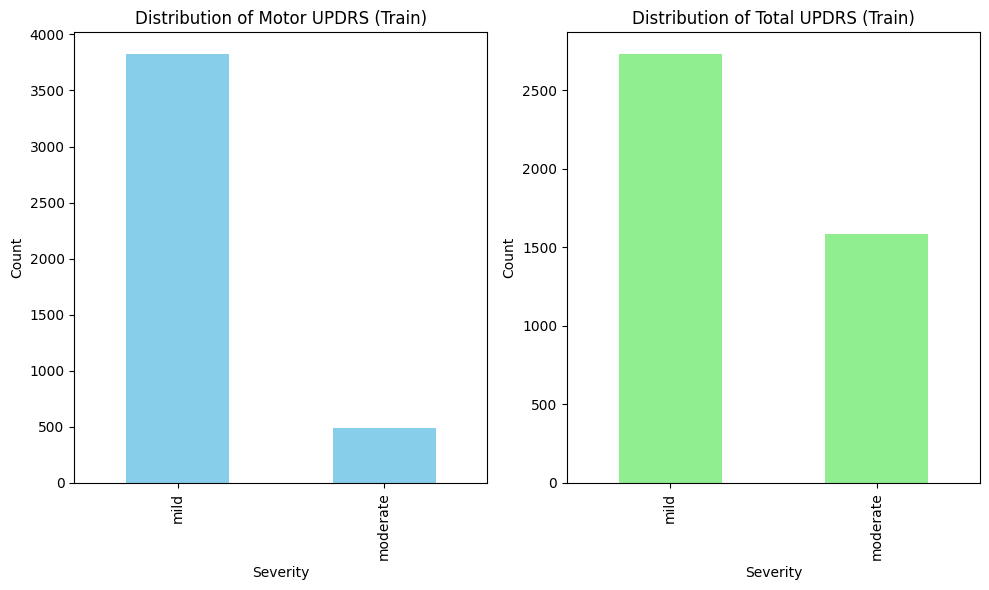

In [405]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
pd.Series(y_train_motor_class).value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Motor UPDRS (Train)')
plt.xlabel('Severity')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
pd.Series(y_train_total_class).value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribution of Total UPDRS (Train)')
plt.xlabel('Severity')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

The distribution is imbalanced. so we go with 2 options: adjusting the thresholds (this might not align with the real world), resampling

## Preprocessing

### Adjusting the Threshold

In [406]:
def get_severity_adjusted_total(score):
    if score < 24:
        return "mild"
    elif score < 34:
        return "moderate"
    else:
        return "severe"

In [407]:
def get_severity_adjusted_motor(score):
    if score < 23:
        return "mild"
    elif score < 40:
        return "moderate"
    else:
        return "severe"

In [408]:
y_train_motor_adjusted_class = y_train_motor.apply(get_severity_adjusted_motor)
y_test_motor_adjusted_class = y_test_motor.apply(get_severity_adjusted_motor)
y_train_total_adjusted_class = y_train_total.apply(get_severity_adjusted_total)
y_test_total_adjusted_class = y_test_total.apply(get_severity_adjusted_total)

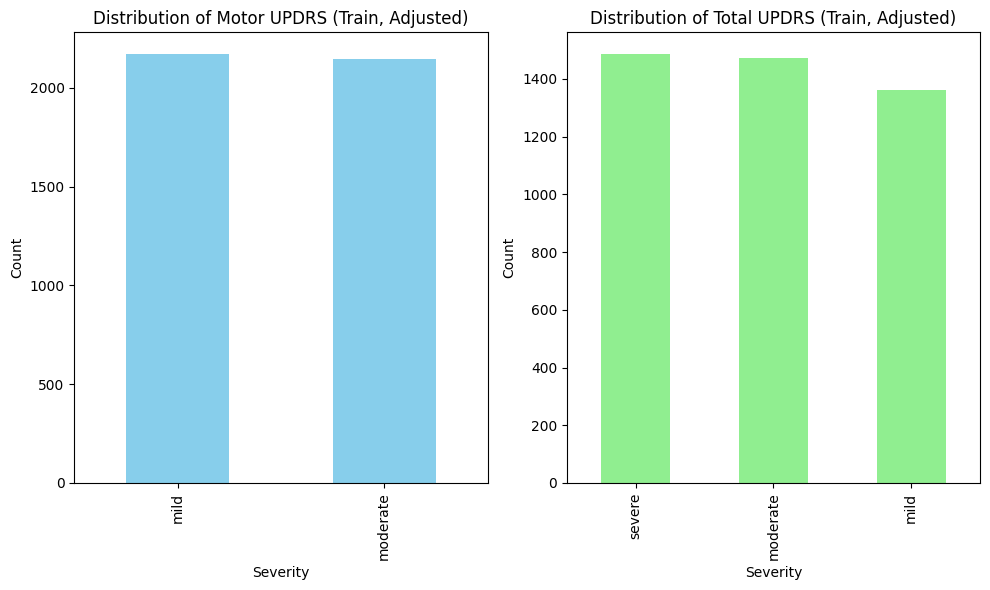

In [409]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
pd.Series(y_train_motor_adjusted_class).value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Motor UPDRS (Train, Adjusted)')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
pd.Series(y_train_total_adjusted_class).value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribution of Total UPDRS (Train, Adjusted)')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

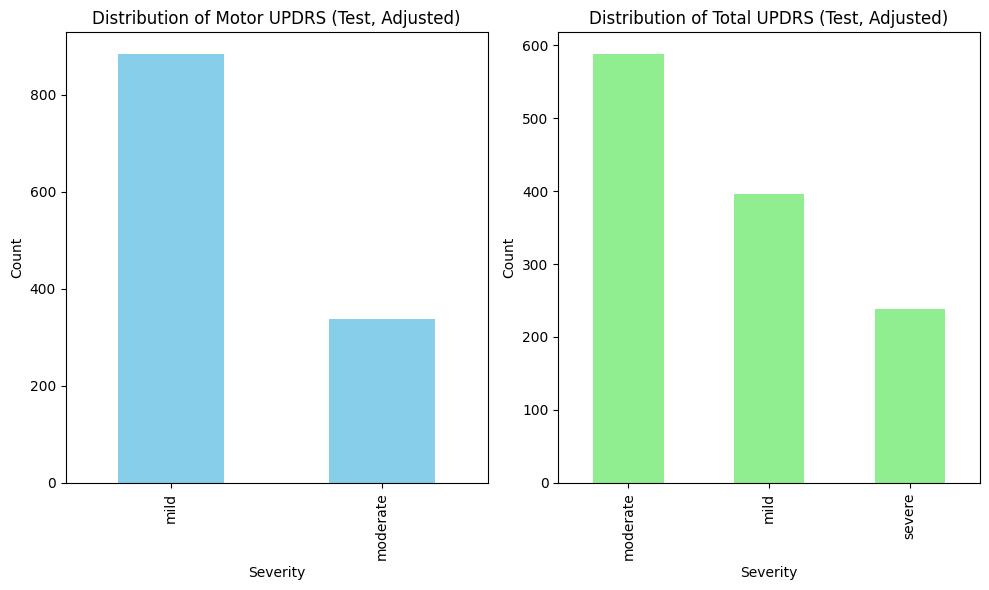

In [410]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
pd.Series(y_test_motor_adjusted_class).value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Motor UPDRS (Test, Adjusted)')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
pd.Series(y_test_total_adjusted_class).value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribution of Total UPDRS (Test, Adjusted)')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Nice!

### Resampling

In [411]:
smote_motor = SMOTE(random_state=42, sampling_strategy='auto')
X_train_motor_resampled, y_train_motor_resampled = smote_motor.fit_resample(X_train_scaled, y_train_motor_class)

smote_total = SMOTE(random_state=42, sampling_strategy='auto')
X_train_total_resampled, y_train_total_resampled = smote_total.fit_resample(X_train_scaled, y_train_total_class)

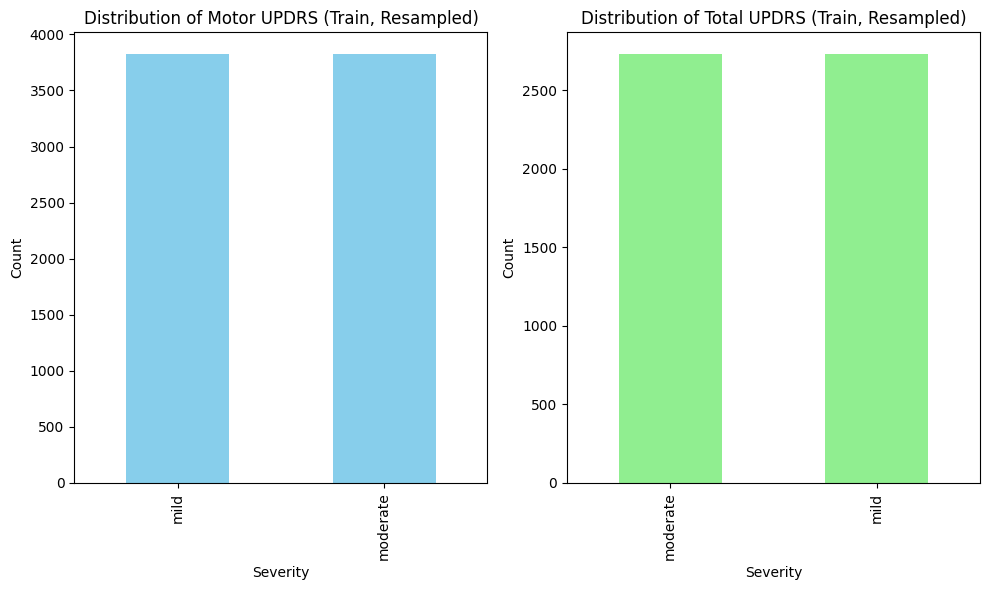

In [412]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
pd.Series(y_train_motor_resampled).value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Motor UPDRS (Train, Resampled)')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
pd.Series(y_train_total_resampled).value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribution of Total UPDRS (Train, Resampled)')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Encoding

In [413]:
label_encoder_motor_adjusted = LabelEncoder()
label_encoder_total_adjusted = LabelEncoder()
label_encoder_motor_resampled = LabelEncoder()
label_encoder_total_resampled = LabelEncoder()

In [414]:
y_train_motor_adjusted_class_encoded = label_encoder_motor_adjusted.fit_transform(y_train_motor_adjusted_class)
y_test_motor_adjusted_class_encoded = label_encoder_motor_adjusted.transform(y_test_motor_adjusted_class)

y_train_total_adjusted_class_encoded = label_encoder_total_adjusted.fit_transform(y_train_total_adjusted_class)
y_test_total_adjusted_class_encoded = label_encoder_total_adjusted.transform(y_test_total_adjusted_class)

y_train_motor_resampled_encoded = label_encoder_motor_resampled.fit_transform(y_train_motor_resampled)
y_test_motor_resampled_encoded = label_encoder_motor_resampled.transform(y_test_motor_class)

y_train_total_resampled_encoded = label_encoder_total_resampled.fit_transform(y_train_total_resampled)
y_test_total_resampled_encoded = label_encoder_total_resampled.transform(y_test_total_class)

## Models

### Random Forest

#### Motor UPDRS Adjusted

In [415]:
param_grid = {
    'n_estimators': [100, 150], 
    'max_depth': [10, 15],     
    'min_samples_split': [5, 10],  
    'min_samples_leaf': [2, 4],   
    'bootstrap': [True],       
    'criterion': ['gini'],
    'max_features': ['sqrt']
}

In [416]:
rf_motor_adjusted = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_motor_adjusted, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train_motor_adjusted_class_encoded)
best_params = grid_search.best_params_
print("Best parameters found by GridSearchCV:")
print(best_params)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found by GridSearchCV:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}


In [417]:
best_rf_model = grid_search.best_estimator_
y_train_motor_adjusted_pred = best_rf_model.predict(X_train_scaled)
y_test_motor_adjusted_pred = best_rf_model.predict(X_test_scaled)
print("Train Accuracy:", accuracy_score(y_train_motor_adjusted_class_encoded, y_train_motor_adjusted_pred))
print("Test Accuracy:", accuracy_score(y_test_motor_adjusted_class_encoded, y_test_motor_adjusted_pred))
print("Classification Report:\n", classification_report(y_test_motor_adjusted_class_encoded, y_test_motor_adjusted_pred))

Train Accuracy: 0.9895809215096087
Test Accuracy: 0.44435351882160395
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.50      0.57       884
           1       0.19      0.30      0.23       338

    accuracy                           0.44      1222
   macro avg       0.42      0.40      0.40      1222
weighted avg       0.52      0.44      0.47      1222



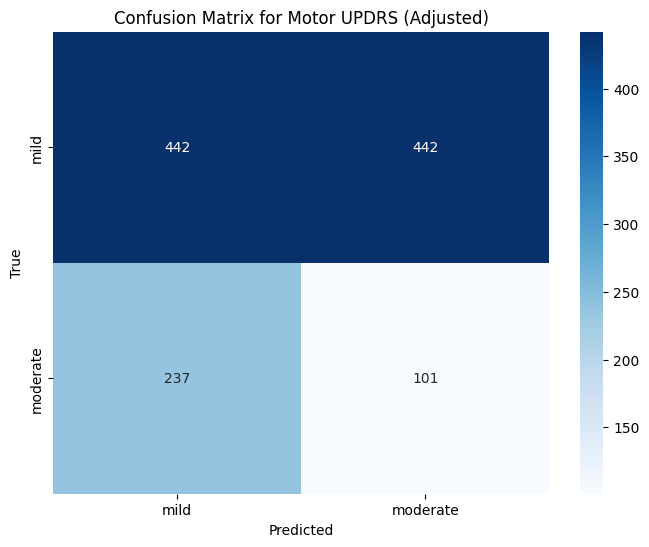

In [418]:
conf_matrix = confusion_matrix(y_test_motor_adjusted_class_encoded, y_test_motor_adjusted_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_motor_adjusted.classes_, yticklabels=label_encoder_motor_adjusted.classes_)
plt.title('Confusion Matrix for Motor UPDRS (Adjusted)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<Figure size 1000x600 with 0 Axes>

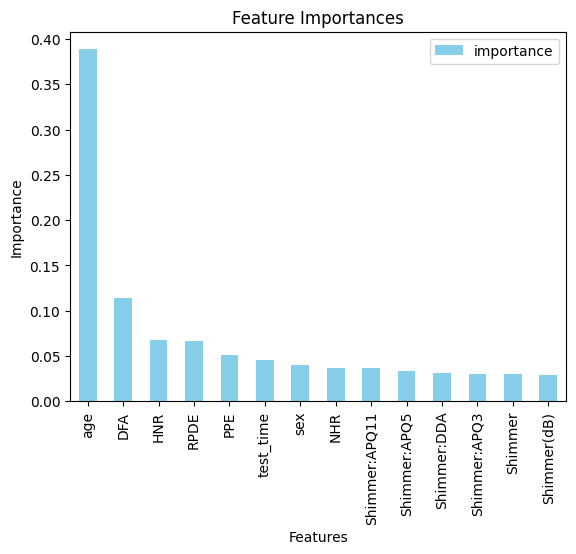

In [419]:
feature_importances = pd.DataFrame(best_rf_model.feature_importances_,
                                   index=X_train_scaled.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [420]:
cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train_motor_adjusted_class_encoded, cv=5, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")


Cross-validation scores: [0.45138889 0.49768519 0.67476852 0.70486111 0.56662804]
Mean cross-validation score: 0.5790663490837303


 The mean cross-validation score is about 0.59, which indicates that while the model performs better than random chance, it can still be significantly improved.

In [421]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(rf_motor_adjusted, X_train_scaled, y_train_motor_adjusted_class_encoded, cv=skf, scoring='accuracy')

print(f"Stratified K-Fold Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Stratified K-Fold Cross-validation scores: [0.93981481 0.95601852 0.9525463  0.93981481 0.94669757]
Mean cross-validation score: 0.9469784022144973


NICE

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Test Accuracy: 0.469721767594108
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.53      0.59       884
           1       0.21      0.32      0.25       338

    accuracy                           0.47      1222
   macro avg       0.44      0.42      0.42      1222
weighted avg       0.54      0.47      0.50      1222



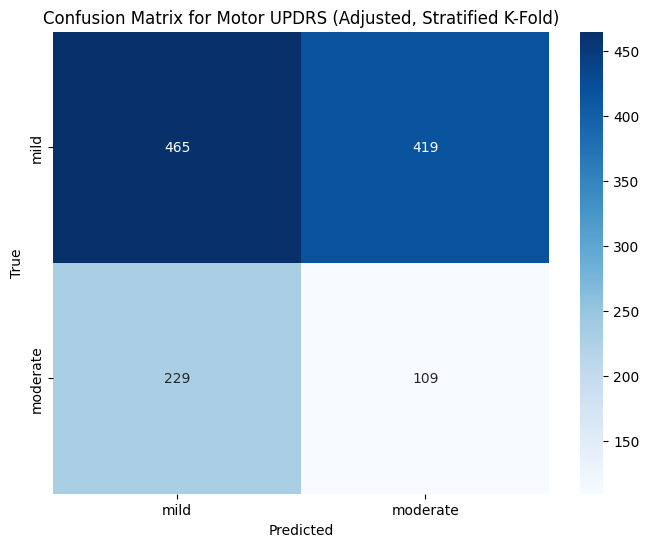

In [422]:
param_grid_skf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True]
}

rf_motor_adjusted_skf = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search_skf = GridSearchCV(estimator=rf_motor_adjusted_skf, param_grid=param_grid_skf, cv=skf, n_jobs=-1, verbose=1, scoring='accuracy')

grid_search_skf.fit(X_train_scaled, y_train_motor_adjusted_class_encoded)

best_params = grid_search_skf.best_params_

final_rf_model_skf = grid_search_skf.best_estimator_

y_test_motor_adjusted_pred_skf = final_rf_model_skf.predict(X_test_scaled)

print("Test Accuracy:", accuracy_score(y_test_motor_adjusted_class_encoded, y_test_motor_adjusted_pred_skf))
print("Classification Report:\n", classification_report(y_test_motor_adjusted_class_encoded, y_test_motor_adjusted_pred_skf))
conf_matrix_skf = confusion_matrix(y_test_motor_adjusted_class_encoded, y_test_motor_adjusted_pred_skf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_skf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_motor_adjusted.classes_, yticklabels=label_encoder_motor_adjusted.classes_)
plt.title('Confusion Matrix for Motor UPDRS (Adjusted, Stratified K-Fold)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Total UPDRS Adjusted

In [423]:
# Random Forest Classifier for Total UPDRS Adjusted
rf_total_adjusted = RandomForestClassifier(n_estimators=100, random_state=42)
rf_total_adjusted.fit(X_train_scaled, y_train_total_adjusted_class_encoded)
y_pred_total_adjusted = rf_total_adjusted.predict(X_test_scaled)
print("Total UPDRS Classification Report (Adjusted):")
print(classification_report(y_test_total_adjusted_class_encoded, y_pred_total_adjusted, target_names=label_encoder_total_adjusted.classes_))
print("Total UPDRS Confusion Matrix (Adjusted):")
confusion_matrix(y_test_total_adjusted_class_encoded, y_pred_total_adjusted)

Total UPDRS Classification Report (Adjusted):
              precision    recall  f1-score   support

        mild       0.36      0.47      0.41       396
    moderate       0.71      0.39      0.50       588
      severe       0.03      0.05      0.04       238

    accuracy                           0.35      1222
   macro avg       0.37      0.30      0.32      1222
weighted avg       0.46      0.35      0.38      1222

Total UPDRS Confusion Matrix (Adjusted):


array([[188,  77, 131],
       [129, 230, 229],
       [210,  17,  11]])

#### Motor UPDRS Resampled

In [424]:
# Random Forest Classifier for Motor UPDRS Resampled
rf_motor_resamplesd = RandomForestClassifier(n_estimators=100, random_state=42)
rf_motor_resamplesd.fit(X_train_motor_resampled, y_train_motor_resampled_encoded)
y_pred_motor_resampled = rf_motor_resamplesd.predict(X_test_scaled)
print("Motor UPDRS Classification Report (Resampled):")
print(classification_report(y_test_motor_resampled_encoded, y_pred_motor_resampled, target_names=label_encoder_motor_adjusted.classes_))
print("Motor UPDRS Confusion Matrix (Resampled):")
confusion_matrix(y_test_motor_resampled_encoded, y_pred_motor_resampled)

Motor UPDRS Classification Report (Resampled):
              precision    recall  f1-score   support

        mild       1.00      0.97      0.98      1222
    moderate       0.00      0.00      0.00         0

    accuracy                           0.97      1222
   macro avg       0.50      0.48      0.49      1222
weighted avg       1.00      0.97      0.98      1222

Motor UPDRS Confusion Matrix (Resampled):


/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/behnazrezaeifar/Documents/Documents - Behnaz’s MacBook Pro/biosignals/biosignal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in lab

array([[1185,   37],
       [   0,    0]])

Test data does not have moderate class only mild and that is the problem here. solution: or split again for classification or use adjusted bins

#### Total UPDRS Resampled

In [425]:
# Random Forest Classifier for Total UPDRS Resampled
target_names_motor_resampled = label_encoder_total_resampled.classes_

rf_total_resampled = RandomForestClassifier(n_estimators=100, random_state=42)
rf_total_resampled.fit(X_train_total_resampled, y_train_total_resampled_encoded)
y_pred_total_resampled = rf_total_resampled.predict(X_test_scaled)

print("Total UPDRS Classification Report (Resampled):")
print(classification_report(y_test_total_resampled_encoded, y_pred_total_resampled, target_names=target_names_motor_resampled))
print("Total UPDRS Confusion Matrix (Resampled):")
print(confusion_matrix(y_test_total_resampled_encoded, y_pred_total_resampled))

Total UPDRS Classification Report (Resampled):
              precision    recall  f1-score   support

        mild       0.71      0.64      0.67       960
    moderate       0.04      0.06      0.05       262

    accuracy                           0.51      1222
   macro avg       0.38      0.35      0.36      1222
weighted avg       0.57      0.51      0.54      1222

Total UPDRS Confusion Matrix (Resampled):
[[610 350]
 [247  15]]
